In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/face-recognition/imgs/Prateek Maheshwari.3.jpg
/kaggle/input/face-recognition/imgs/zaid alam.5.jpg
/kaggle/input/face-recognition/imgs/harsh kajalkhane .33.jpg
/kaggle/input/face-recognition/imgs/vishal meena.10.jpg
/kaggle/input/face-recognition/imgs/SUJIT TAYADE.38.jpg
/kaggle/input/face-recognition/imgs/nikhil chaudhary.13.jpg
/kaggle/input/face-recognition/imgs/Prateek Maheshwari.19.jpg
/kaggle/input/face-recognition/imgs/AMAN KHERIA.18.jpg
/kaggle/input/face-recognition/imgs/harsh kajalkhane .22.jpg
/kaggle/input/face-recognition/imgs/AMAN KHERIA.7.jpg
/kaggle/input/face-recognition/imgs/HARSHVARDHAN.15.jpg
/kaggle/input/face-recognition/imgs/ARPIT KUMAR.32.jpg
/kaggle/input/face-recognition/imgs/zaid alam.23.jpg
/kaggle/input/face-recognition/imgs/bhargav.33.jpg
/kaggle/input/face-recognition/imgs/rajkumar bairwa.23.jpg
/kaggle/input/face-recognition/imgs/ARPIT KUMAR.28.jpg
/kaggle/input/face-recognition/imgs/nikhil chaudhary.25.jpg
/kaggle/input/face-recognition/im

# **Model Training with CNN**

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Flatten
import os
from PIL import Image
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Rescaling
from tensorflow.keras import datasets, layers, models
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models, Input

2024-07-30 19:41:08.067963: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-30 19:41:08.068085: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-30 19:41:08.209864: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
imgs = '/kaggle/input/face-recognition/imgs'

def get_image_sizes(directory, sample_size=10):
    image_sizes = []
    count = 0
    for subdir, _, files in os.walk(directory):
        for file in files:
            if file.endswith(('jpg', 'jpeg', 'png')):
                image_path = os.path.join(subdir, file)
                with Image.open(image_path) as img:
                    image_sizes.append(img.size)
                    count += 1
                    if count >= sample_size:
                        break
        if count >= sample_size:
            break
    return image_sizes

# Checking the size of images that it is 450 by 450 or not
image_sizes = get_image_sizes(imgs)

print("Sample image sizes:", image_sizes)

Sample image sizes: [(450, 450), (450, 450), (450, 450), (450, 450), (450, 450), (450, 450), (450, 450), (450, 450), (450, 450), (450, 450)]


In [13]:
# Function to augment data
def augment_data(img):
    datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )
    img = np.expand_dims(img, axis=-1)  
    augmented_images = datagen.flow(np.expand_dims(img, axis=0), batch_size=32)
    augmented_images = [next(augmented_images)[0].astype(np.uint8) for _ in range(3)]
    return augmented_images


In [14]:
# Loading and preprocessing the data
def load_data(data_dir):
    path = [os.path.join(data_dir, file) for file in os.listdir(data_dir)]
    faces = []
    names = []

    for image in path:
        img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
        name, ext = os.path.splitext(os.path.basename(image))
        label = name.split(".")[0]  
        faces.append(img)
        names.append(label)
    
    faces = np.array(faces)
    names = np.array(names)
    return faces, names

In [15]:
def augment_training_data(train_faces, train_names):
    augmented_faces = []
    augmented_names = []

    for img, name in zip(train_faces, train_names):
        augmented_images = augment_data(img)
        for augmented_img in augmented_images:
            augmented_faces.append(augmented_img)
            augmented_names.append(name)

    augmented_faces = np.array(augmented_faces)  
    augmented_names = np.array(augmented_names) 
    
    if augmented_faces.shape[1:] != train_faces.shape[1:]:
        augmented_faces = augmented_faces.reshape((-1,) + train_faces.shape[1:])
    
    return np.concatenate((train_faces, augmented_faces)), np.concatenate((train_names, augmented_names))


In [16]:
def split_data(faces, names):
    train_faces, val_faces, train_names, val_names = train_test_split(faces, names, test_size=0.3, random_state=42, stratify=names)
    return train_faces, val_faces, train_names, val_names

In [17]:
# Label encoding the names
def encode_labels(train_names, val_names):
    label_encoder = LabelEncoder()
    train_labels = label_encoder.fit_transform(train_names)
    val_labels = label_encoder.transform(val_names)
    return train_labels, val_labels, label_encoder


In [18]:
def main(data_dir):
    faces, names = load_data(data_dir)
    
    # Printing the original names to check that it is extracting the right name of person
    print("Original names:")
    for name in names[:10]:  
        print(name)
    
    train_faces, val_faces, train_names, val_names = split_data(faces, names)
    
    print(f"Train faces shape after split: {train_faces.shape}, dtype: {train_faces.dtype}")
    print(f"Val faces shape after split: {val_faces.shape}, dtype: {val_faces.dtype}")
    
    train_faces, train_names = augment_training_data(train_faces, train_names)
    
    print(f"Train faces shape after augmentation: {train_faces.shape}, dtype: {train_faces.dtype}")
    print(f"Train names shape after augmentation: {train_names.shape}, dtype: {train_names.dtype}")
   
    train_faces = train_faces / 255.0
    val_faces = val_faces / 255.0
    
    train_labels, val_labels, label_encoder = encode_labels(train_names, val_names)
    
    
    print(f"Number of classes: {len(label_encoder.classes_)}")
    
    return train_faces, val_faces, train_labels, val_labels, label_encoder

In [19]:
data_dir = '/kaggle/input/face-recognition/imgs'  
train_faces, val_faces, train_labels, val_labels, label_encoder = main(data_dir)

Original names:
Prateek Maheshwari
zaid alam
harsh kajalkhane 
vishal meena
SUJIT TAYADE
nikhil chaudhary
Prateek Maheshwari
AMAN KHERIA
harsh kajalkhane 
AMAN KHERIA
Train faces shape after split: (1527, 450, 450), dtype: uint8
Val faces shape after split: (655, 450, 450), dtype: uint8
Train faces shape after augmentation: (6108, 450, 450), dtype: uint8
Train names shape after augmentation: (6108,), dtype: <U21
Number of classes: 56


In [20]:
train_faces[0]

array([[0.11372549, 0.11764706, 0.11372549, ..., 0.11372549, 0.11372549,
        0.11372549],
       [0.11372549, 0.11372549, 0.11764706, ..., 0.11764706, 0.11372549,
        0.11372549],
       [0.10980392, 0.10980392, 0.11372549, ..., 0.11372549, 0.11372549,
        0.11372549],
       ...,
       [0.11372549, 0.10980392, 0.11764706, ..., 0.1254902 , 0.11372549,
        0.11372549],
       [0.11372549, 0.11372549, 0.11372549, ..., 0.11372549, 0.11372549,
        0.11372549],
       [0.11372549, 0.11372549, 0.11372549, ..., 0.11372549, 0.11372549,
        0.11372549]])

In [21]:
val_faces[0]

array([[0.10980392, 0.11764706, 0.11764706, ..., 0.10980392, 0.11372549,
        0.11372549],
       [0.11372549, 0.11764706, 0.11372549, ..., 0.11372549, 0.11372549,
        0.11372549],
       [0.11372549, 0.11372549, 0.10980392, ..., 0.11372549, 0.11372549,
        0.11372549],
       ...,
       [0.11372549, 0.11372549, 0.11372549, ..., 0.12941176, 0.11764706,
        0.11372549],
       [0.11372549, 0.11372549, 0.11372549, ..., 0.11764706, 0.11372549,
        0.11372549],
       [0.11372549, 0.11372549, 0.11372549, ..., 0.11372549, 0.11372549,
        0.11372549]])

 Plotting some images of different persons so we can see that right name is extracted for person

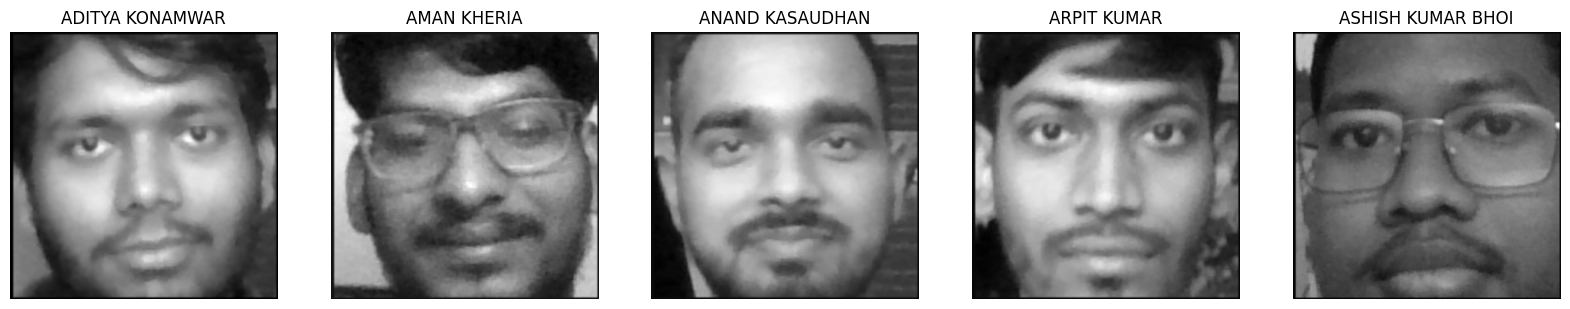

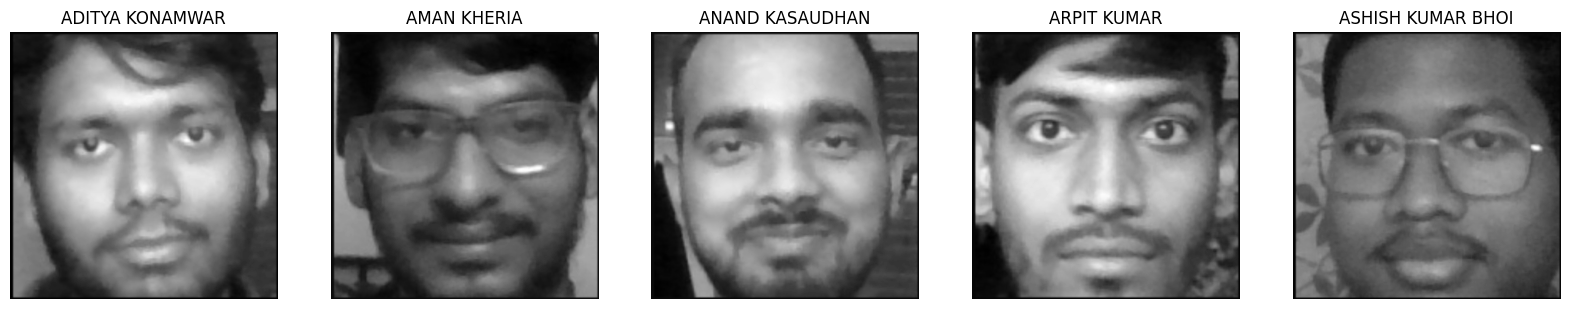

In [22]:
import matplotlib.pyplot as plt
def plot_images(faces, labels, label_encoder, num_images=5):
    unique_labels = np.unique(labels)
    plt.figure(figsize=(20, 20))
    for i, label in enumerate(unique_labels[:num_images]):
        idx = np.where(labels == label)[0][0]  # Get the first occurrence of the label
        img = faces[idx]
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(label_encoder.inverse_transform([label])[0])
        plt.axis('off')
    plt.show()

plot_images(train_faces, train_labels, label_encoder)

plot_images(val_faces, val_labels, label_encoder)

In [23]:
cnn = models.Sequential([
    layers.Conv2D(filters=64, kernel_size=(5,5), activation='relu', input_shape=(450 ,450, 1)),
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu',padding='same',strides=2),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu',padding='same',strides=2),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu',padding='same',strides=2),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu',padding='same',strides=2),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(56, activation='softmax')
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 446, 446, 64)   │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 223, 223, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 55, 55, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 27, 27, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 25, 25, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 13, 13, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 2, 2, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 1, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │         8,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 56)             │           952 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 141,032 (550.91 KB)

 Trainable params: 141,032 (550.91 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
adam_optimizer = optimizers.Adam(learning_rate=1e-4)

cnn.compile(optimizer=adam_optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [28]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',  
    patience=5,           
    restore_best_weights=True 
)
history = cnn.fit(train_faces, train_labels, epochs=50, validation_data=(val_faces, val_labels),callbacks=[early_stopping])

Epoch 1/50
  1/191 ━━━━━━━━━━━━━━━━━━━━ 1:06:00 21s/step - accuracy: 0.0938 - loss: 4.0254

I0000 00:00:1722347678.197209     260 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


191/191 ━━━━━━━━━━━━━━━━━━━━ 67s 243ms/step - accuracy: 0.0251 - loss: 4.0252 - val_accuracy: 0.0183 - val_loss: 4.0161
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 24s 128ms/step - accuracy: 0.0303 - loss: 3.9548 - val_accuracy: 0.1160 - val_loss: 3.5602
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 24s 128ms/step - accuracy: 0.1184 - loss: 3.5384 - val_accuracy: 0.2473 - val_loss: 2.8764
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 24s 128ms/step - accuracy: 0.2374 - loss: 2.9625 - val_accuracy: 0.4351 - val_loss: 2.2661
Epoch 5/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 25s 131ms/step - accuracy: 0.3774 - loss: 2.4336 - val_accuracy: 0.5756 - val_loss: 1.7272
Epoch 6/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 25s 128ms/step - accuracy: 0.4963 - loss: 1.9264 - val_accuracy: 0.6321 - val_loss: 1.4324
Epoch 7/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 24s 128ms/step - accuracy: 0.5825 - loss: 1.5976 - val_accuracy: 0.7267 - val_loss: 1.1590
Epoch 8/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 24s 128ms/step - accuracy: 0.6481 - loss: 1.3611 - val

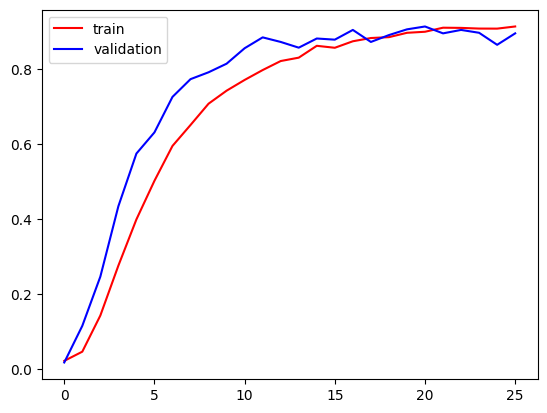

In [29]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

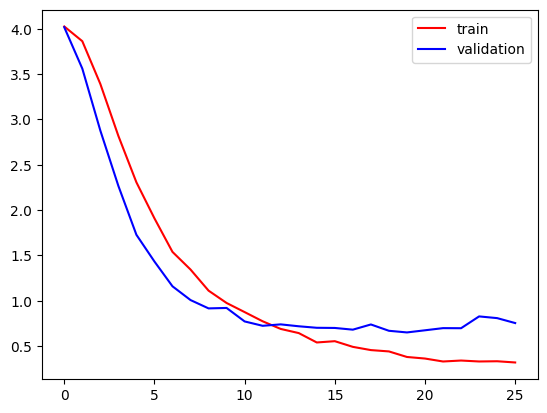

In [30]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

# **Transfer Learning with ResNet**

### Again loaing the dataset and doing preprocessing on it

In [31]:
import cv2
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

def load_data(data_dir):
    path = [os.path.join(data_dir, file) for file in os.listdir(data_dir)]
    faces = []
    names = []

    for image in path:
        img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
        name, ext = os.path.splitext(os.path.basename(image))
        label = name.split(".")[0]  # Extract the name part
        faces.append(img)
        names.append(label)
    
    faces = np.array(faces)
    names = np.array(names)
    return faces, names


def encode_labels(names):
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(names)
    return encoded_labels, label_encoder

def split_data(faces, labels):
    train_faces, val_faces, train_labels, val_labels = train_test_split(faces, labels, test_size=0.2, random_state=42, stratify=labels)
    return train_faces, val_faces, train_labels, val_labels

def main(data_dir):
    faces, names = load_data(data_dir)
    
   
    print("Original names:")
    for name in names[:10]:  
        print(name)
   
    train_labels, label_encoder = encode_labels(names)
    
    print(f"Number of classes: {len(label_encoder.classes_)}")
    
    train_faces, val_faces, train_labels, val_labels = split_data(faces, train_labels)
    
    print(f"Train labels shape after encoding: {train_labels.shape}, dtype: {train_labels.dtype}")
    print(f"Val labels shape after encoding: {val_labels.shape}, dtype: {val_labels.dtype}")

    return train_faces, val_faces, train_labels, val_labels, label_encoder

data_dir = '/kaggle/input/face-recognition/imgs'  
train_faces, val_faces, train_labels, val_labels, label_encoder = main(data_dir)


Original names:
Prateek Maheshwari
zaid alam
harsh kajalkhane 
vishal meena
SUJIT TAYADE
nikhil chaudhary
Prateek Maheshwari
AMAN KHERIA
harsh kajalkhane 
AMAN KHERIA
Number of classes: 56
Train labels shape after encoding: (1745,), dtype: int64
Val labels shape after encoding: (437,), dtype: int64


Converting Greyscate to RGB

In [32]:
batch_size = 32

def preprocess_images(images):
    num_images = len(images)
    processed_images = np.zeros((num_images,) + images.shape[1:] + (3,), dtype=np.float32)

    for start in range(0, num_images, batch_size):
        end = min(start + batch_size, num_images)
        batch_images = images[start:end]

        # Converting and normalizing batch of images
        for i, x in enumerate(batch_images):
            rgb_image = cv2.cvtColor(x, cv2.COLOR_GRAY2RGB)
            processed_images[start + i] = rgb_image / 255.0

    return processed_images

train_faces_processed = preprocess_images(train_faces)
val_faces_processed = preprocess_images(val_faces)

In [33]:
train_faces_processed.shape

(1745, 450, 450, 3)

In [34]:
val_faces_processed.shape

(437, 450, 450, 3)

In [35]:
train_faces_processed[0]

array([[[0.10980392, 0.10980392, 0.10980392],
        [0.11764706, 0.11764706, 0.11764706],
        [0.11764706, 0.11764706, 0.11764706],
        ...,
        [0.10980392, 0.10980392, 0.10980392],
        [0.11372549, 0.11372549, 0.11372549],
        [0.11764706, 0.11764706, 0.11764706]],

       [[0.11372549, 0.11372549, 0.11372549],
        [0.10980392, 0.10980392, 0.10980392],
        [0.10588235, 0.10588235, 0.10588235],
        ...,
        [0.11372549, 0.11372549, 0.11372549],
        [0.10980392, 0.10980392, 0.10980392],
        [0.11372549, 0.11372549, 0.11372549]],

       [[0.12156863, 0.12156863, 0.12156863],
        [0.11372549, 0.11372549, 0.11372549],
        [0.11372549, 0.11372549, 0.11372549],
        ...,
        [0.11764706, 0.11764706, 0.11764706],
        [0.10980392, 0.10980392, 0.10980392],
        [0.10980392, 0.10980392, 0.10980392]],

       ...,

       [[0.12156863, 0.12156863, 0.12156863],
        [0.11764706, 0.11764706, 0.11764706],
        [0.11372549, 0

In [103]:
val_faces_processed[0]

array([[[0.11372549, 0.11372549, 0.11372549],
        [0.11372549, 0.11372549, 0.11372549],
        [0.11372549, 0.11372549, 0.11372549],
        ...,
        [0.10980392, 0.10980392, 0.10980392],
        [0.10980392, 0.10980392, 0.10980392],
        [0.10980392, 0.10980392, 0.10980392]],

       [[0.11372549, 0.11372549, 0.11372549],
        [0.11372549, 0.11372549, 0.11372549],
        [0.11764706, 0.11764706, 0.11764706],
        ...,
        [0.10980392, 0.10980392, 0.10980392],
        [0.11372549, 0.11372549, 0.11372549],
        [0.10980392, 0.10980392, 0.10980392]],

       [[0.11372549, 0.11372549, 0.11372549],
        [0.11372549, 0.11372549, 0.11372549],
        [0.11372549, 0.11372549, 0.11372549],
        ...,
        [0.11372549, 0.11372549, 0.11372549],
        [0.11764706, 0.11764706, 0.11764706],
        [0.10980392, 0.10980392, 0.10980392]],

       ...,

       [[0.11372549, 0.11372549, 0.11372549],
        [0.11372549, 0.11372549, 0.11372549],
        [0.11372549, 0

In [36]:
target_size = (224, 224)
train_faces_processed_resized = np.zeros((train_faces_processed.shape[0],) + target_size + (3,), dtype=np.float32)
val_faces_processed_resized = np.zeros((val_faces_processed.shape[0],) + target_size + (3,), dtype=np.float32)

for i, img in enumerate(train_faces_processed):
    train_faces_processed_resized[i] = cv2.resize(img, target_size)

for i, img in enumerate(val_faces_processed):
    val_faces_processed_resized[i] = cv2.resize(img, target_size)

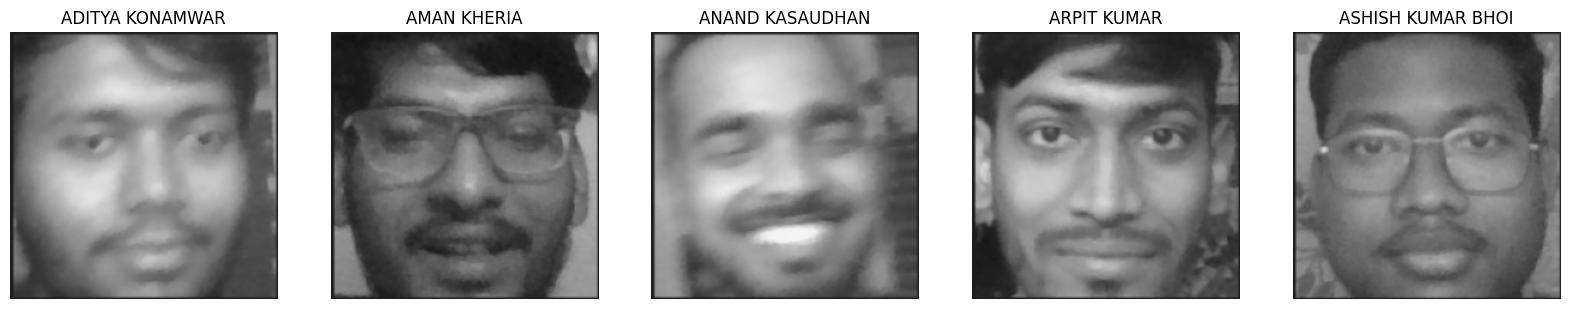

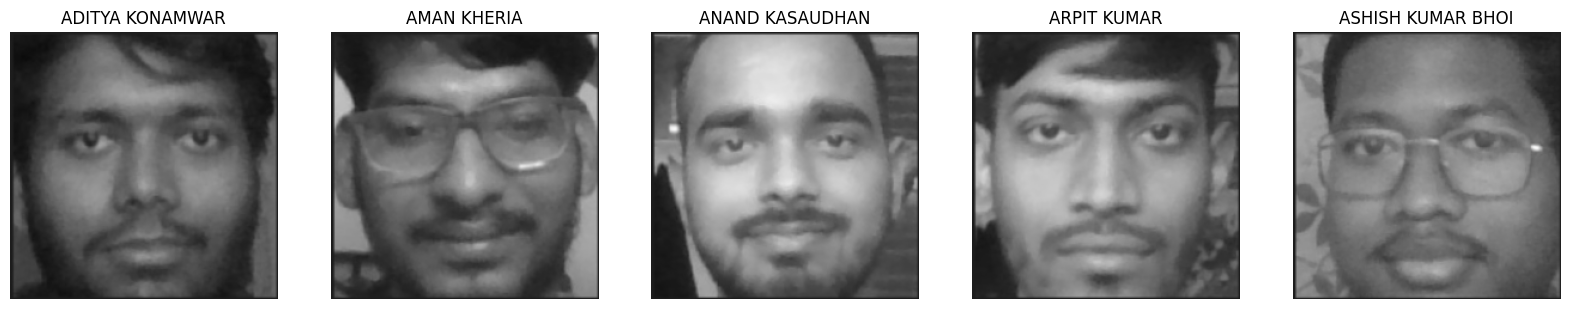

In [37]:
def plot_images(faces, labels, label_encoder, num_images=5):
    unique_labels = np.unique(labels)
    plt.figure(figsize=(20, 20))
    for i, label in enumerate(unique_labels[:num_images]):
        idx = np.where(labels == label)[0][0]  
        img = faces[idx]
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(label_encoder.inverse_transform([label])[0])
        plt.axis('off')
    plt.show()

plot_images(train_faces_processed_resized, train_labels, label_encoder)
plot_images(val_faces_processed_resized, val_labels, label_encoder)

In [38]:
from tensorflow.keras.applications import ResNet50

conv_base = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [39]:
conv_base.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [40]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'conv5_block1_out': 
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
for layer in conv_base.layers:
    print(layer.name, layer.trainable)


input_layer_1 False
conv1_pad False
conv1_conv False
conv1_bn False
conv1_relu False
pool1_pad False
pool1_pool False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_2_bn False
conv2_block1_2_relu False
conv2_block1_0_conv False
conv2_block1_3_conv False
conv2_block1_0_bn False
conv2_block1_3_bn False
conv2_block1_add False
conv2_block1_out False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv2_block2_2_bn False
conv2_block2_2_relu False
conv2_block2_3_conv False
conv2_block2_3_bn False
conv2_block2_add False
conv2_block2_out False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_conv False
conv2_block3_2_bn False
conv2_block3_2_relu False
conv2_block3_3_conv False
conv2_block3_3_bn False
conv2_block3_add False
conv2_block3_out False
conv3_block1_1_conv False
conv3_block1_1_bn False
conv3_block1_1_relu False
conv3_block1

In [41]:
conv_base.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 8,931,328 (34.07 MB)

 Non-trainable params: 14,656,384 (55.91 MB)

In [42]:
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(56,activation='softmax'))

In [43]:
adam_optimizer = optimizers.Adam(learning_rate=1e-4)

model.compile(optimizer=adam_optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [44]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',  
    patience=5,           
    restore_best_weights=True 
)
history = model.fit(
    train_faces_processed_resized,  
    train_labels,                  
    epochs=40,
    validation_data=(val_faces_processed_resized, val_labels),
    callbacks=[early_stopping]
)

Epoch 1/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 40s 386ms/step - accuracy: 0.0701 - loss: 3.9312 - val_accuracy: 0.0137 - val_loss: 4.0627
Epoch 2/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.3403 - loss: 2.7203 - val_accuracy: 0.0160 - val_loss: 4.0555
Epoch 3/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.6133 - loss: 1.6992 - val_accuracy: 0.0183 - val_loss: 4.0541
Epoch 4/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.7507 - loss: 1.0669 - val_accuracy: 0.0137 - val_loss: 4.1559
Epoch 5/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.8544 - loss: 0.6367 - val_accuracy: 0.0732 - val_loss: 3.7690
Epoch 6/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.9067 - loss: 0.4194 - val_accuracy: 0.2792 - val_loss: 3.1408
Epoch 7/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.9274 - loss: 0.3156 - val_accuracy: 0.4737 - val_loss: 2.0968
Epoch 8/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.9247 - loss: 0.2914 - val_accuracy: 0.6728 -

In [45]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 56)             │         3,640 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,594,218 (452.40 MB)

 Trainable params: 34,645,944 (132.16 MB)

 Non-trainable params: 14,656,384 (55.91 MB)

 Optimizer params: 69,291,890 (264.33 MB)

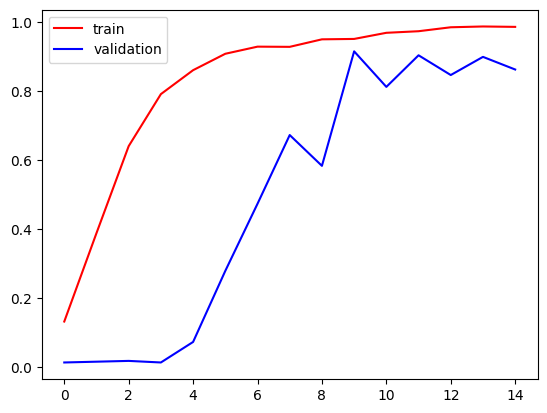

In [46]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

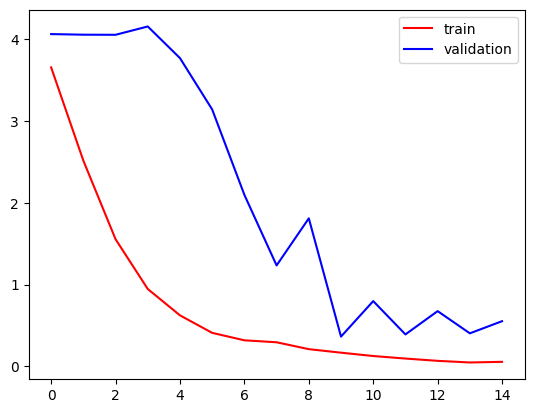

In [47]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

# **Transfer Learning with Inception**

**Again loaing the dataset and doing preprocessing on it**

In [4]:
import cv2
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

def load_data(data_dir):
    path = [os.path.join(data_dir, file) for file in os.listdir(data_dir)]
    faces = []
    names = []

    for image in path:
        img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
        name, ext = os.path.splitext(os.path.basename(image))
        label = name.split(".")[0]  # Extract the name part
        faces.append(img)
        names.append(label)
    
    faces = np.array(faces)
    names = np.array(names)
    return faces, names

def encode_labels(names):
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(names)
    return encoded_labels, label_encoder

def split_data(faces, labels):
    train_faces, val_faces, train_labels, val_labels = train_test_split(faces, labels, test_size=0.2, random_state=42, stratify=labels)
    return train_faces, val_faces, train_labels, val_labels

def main(data_dir):
    
    faces, names = load_data(data_dir)
    
    print("Original names:")
    for name in names[:10]:  
        print(name)
    
    train_labels, label_encoder = encode_labels(names)
   
    print(f"Number of classes: {len(label_encoder.classes_)}")
    
    train_faces, val_faces, train_labels, val_labels = split_data(faces, train_labels)
    
    print(f"Train labels shape after encoding: {train_labels.shape}, dtype: {train_labels.dtype}")
    print(f"Val labels shape after encoding: {val_labels.shape}, dtype: {val_labels.dtype}")

    return train_faces, val_faces, train_labels, val_labels, label_encoder

data_dir = '/kaggle/input/face-recognition/imgs'  
train_faces, val_faces, train_labels, val_labels, label_encoder = main(data_dir)


Original names:
Prateek Maheshwari
zaid alam
harsh kajalkhane 
vishal meena
SUJIT TAYADE
nikhil chaudhary
Prateek Maheshwari
AMAN KHERIA
harsh kajalkhane 
AMAN KHERIA
Number of classes: 56
Train labels shape after encoding: (1745,), dtype: int64
Val labels shape after encoding: (437,), dtype: int64


In [5]:
batch_size = 32

def preprocess_images(images):
    num_images = len(images)
    processed_images = np.zeros((num_images,) + images.shape[1:] + (3,), dtype=np.float32)

    for start in range(0, num_images, batch_size):
        end = min(start + batch_size, num_images)
        batch_images = images[start:end]

        # Convert and normalize batch of images
        for i, x in enumerate(batch_images):
            rgb_image = cv2.cvtColor(x, cv2.COLOR_GRAY2RGB)
            processed_images[start + i] = rgb_image / 255.0

    return processed_images

train_faces_processed = preprocess_images(train_faces)
val_faces_processed = preprocess_images(val_faces)

In [6]:
target_size = (299, 299)
train_faces_processed_resized = np.zeros((train_faces_processed.shape[0],) + target_size + (3,), dtype=np.float32)
val_faces_processed_resized = np.zeros((val_faces_processed.shape[0],) + target_size + (3,), dtype=np.float32)

for i, img in enumerate(train_faces_processed):
    train_faces_processed_resized[i] = cv2.resize(img, target_size)

for i, img in enumerate(val_faces_processed):
    val_faces_processed_resized[i] = cv2.resize(img, target_size)

Checking Train and validation set shape

In [6]:
train_faces_processed_resized.shape

(1745, 299, 299, 3)

In [7]:
 val_faces_processed_resized.shape

(437, 299, 299, 3)

In [8]:
train_faces_processed_resized[0]

array([[[0.11202449, 0.11202449, 0.11202449],
        [0.11491648, 0.11491648, 0.11491648],
        [0.11434803, 0.11434803, 0.11434803],
        ...,
        [0.11639685, 0.11639685, 0.11639685],
        [0.11126482, 0.11126482, 0.11126482],
        [0.11566661, 0.11566661, 0.11566661]],

       [[0.11792651, 0.11792651, 0.11792651],
        [0.11205429, 0.11205429, 0.11205429],
        [0.11747611, 0.11747611, 0.11747611],
        ...,
        [0.11191598, 0.11191598, 0.11191598],
        [0.11502498, 0.11502498, 0.11502498],
        [0.1105147 , 0.1105147 , 0.1105147 ]],

       [[0.11109348, 0.11109348, 0.11109348],
        [0.11561369, 0.11561369, 0.11561369],
        [0.11089296, 0.11089296, 0.11089296],
        ...,
        [0.15326682, 0.15326682, 0.15326682],
        [0.1261121 , 0.1261121 , 0.1261121 ],
        [0.11359389, 0.11359389, 0.11359389]],

       ...,

       [[0.11087285, 0.11087285, 0.11087285],
        [0.11154309, 0.11154309, 0.11154309],
        [0.15409966, 0

In [9]:
val_faces_processed_resized[0]

array([[[0.11372549, 0.11372549, 0.11372549],
        [0.11447562, 0.11447562, 0.11447562],
        [0.11372549, 0.11372549, 0.11372549],
        ...,
        [0.11748967, 0.11748967, 0.11748967],
        [0.11004402, 0.11004402, 0.11004402],
        [0.11005396, 0.11005396, 0.11005396]],

       [[0.11372549, 0.11372549, 0.11372549],
        [0.11444581, 0.11444581, 0.11444581],
        [0.1107548 , 0.1107548 , 0.1107548 ],
        ...,
        [0.11752902, 0.11752902, 0.11752902],
        [0.11372549, 0.11372549, 0.11372549],
        [0.11154427, 0.11154427, 0.11154427]],

       [[0.11156375, 0.11156375, 0.11156375],
        [0.11153473, 0.11153473, 0.11153473],
        [0.11789545, 0.11789545, 0.11789545],
        ...,
        [0.14885055, 0.14885055, 0.14885055],
        [0.13064715, 0.13064715, 0.13064715],
        [0.11622591, 0.11622591, 0.11622591]],

       ...,

       [[0.10841178, 0.10841178, 0.10841178],
        [0.1157453 , 0.1157453 , 0.1157453 ],
        [0.19530094, 0

**Plotting 5 images from train and valid set with name**

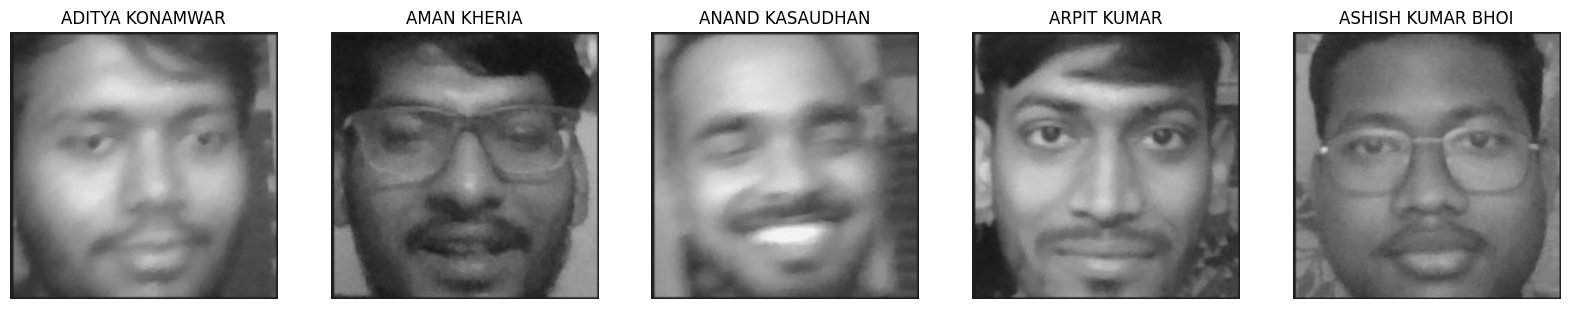

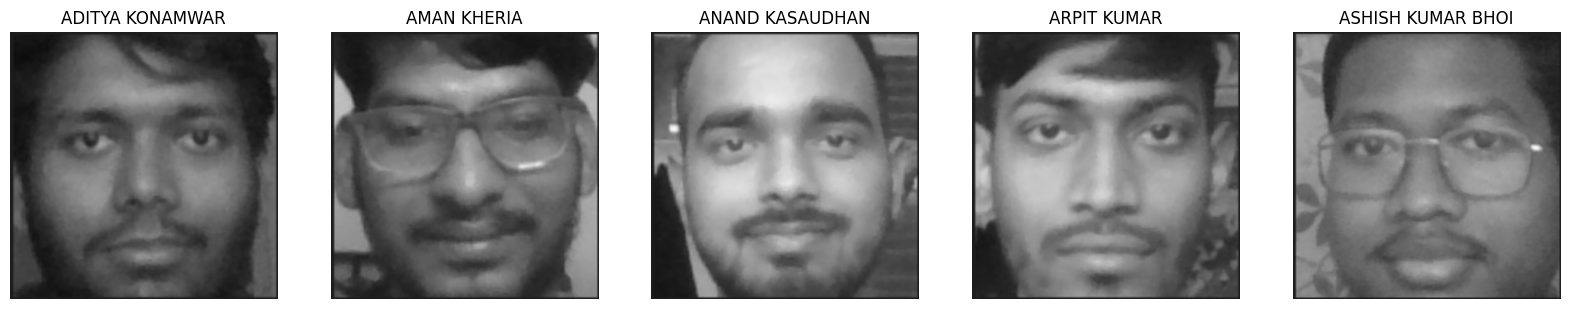

In [32]:
def plot_images(faces, labels, label_encoder, num_images=5):
    unique_labels = np.unique(labels)
    plt.figure(figsize=(20, 20))
    for i, label in enumerate(unique_labels[:num_images]):
        idx = np.where(labels == label)[0][0]  
        img = faces[idx]
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(label_encoder.inverse_transform([label])[0])
        plt.axis('off')
    plt.show()

plot_images(train_faces_processed_resized, train_labels, label_encoder)
plot_images(val_faces_processed_resized, val_labels, label_encoder)

In [9]:
from tensorflow.keras.applications import InceptionV3


inception_base = InceptionV3(
    weights='imagenet',    
    include_top=False,     
    input_shape=(299, 299, 3) 
)

In [8]:
inception_base.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [10]:
inception_base.trainable = True
set_trainable = False
for layer in inception_base.layers:
    if layer.name == 'mixed7': 
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

for layer in inception_base.layers:
    print(layer.name, layer.trainable)

input_layer_1 False
conv2d_94 False
batch_normalization_94 False
activation_94 False
conv2d_95 False
batch_normalization_95 False
activation_95 False
conv2d_96 False
batch_normalization_96 False
activation_96 False
max_pooling2d_4 False
conv2d_97 False
batch_normalization_97 False
activation_97 False
conv2d_98 False
batch_normalization_98 False
activation_98 False
max_pooling2d_5 False
conv2d_102 False
batch_normalization_102 False
activation_102 False
conv2d_100 False
conv2d_103 False
batch_normalization_100 False
batch_normalization_103 False
activation_100 False
activation_103 False
average_pooling2d_9 False
conv2d_99 False
conv2d_101 False
conv2d_104 False
conv2d_105 False
batch_normalization_99 False
batch_normalization_101 False
batch_normalization_104 False
batch_normalization_105 False
activation_99 False
activation_101 False
activation_104 False
activation_105 False
mixed0 False
conv2d_109 False
batch_normalization_109 False
activation_109 False
conv2d_107 False
conv2d_110 Fal

In [9]:
inception_base.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 12,811,904 (48.87 MB)

 Non-trainable params: 8,990,880 (34.30 MB)

In [11]:
model_2 = Sequential()

model_2.add(inception_base)
model_2.add(Flatten())
model_2.add(Dense(128,activation='relu'))
model_2.add(Dense(32,activation='relu'))
model_2.add(Dense(56,activation='softmax'))

In [12]:
adam_optimizer = optimizers.Adam(learning_rate=1e-4)

model_2.compile(optimizer=adam_optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',  
    patience=5,           
    restore_best_weights=True 
)
history = model_2.fit(
    train_faces_processed_resized,  
    train_labels,                  
    epochs=40,
    validation_data=(val_faces_processed_resized, val_labels),
    callbacks=[early_stopping]
)

Epoch 1/40
 1/55 ━━━━━━━━━━━━━━━━━━━━ 35:12 39s/step - accuracy: 0.0312 - loss: 4.2312

I0000 00:00:1722368809.093375     116 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


55/55 ━━━━━━━━━━━━━━━━━━━━ 82s 803ms/step - accuracy: 0.2327 - loss: 3.1201 - val_accuracy: 0.4600 - val_loss: 2.0804
Epoch 2/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - accuracy: 0.8543 - loss: 0.5328 - val_accuracy: 0.8032 - val_loss: 0.7716
Epoch 3/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 0.9543 - loss: 0.1777 - val_accuracy: 0.9199 - val_loss: 0.3372
Epoch 4/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 0.9726 - loss: 0.0841 - val_accuracy: 0.9314 - val_loss: 0.2948
Epoch 5/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - accuracy: 0.9803 - loss: 0.0636 - val_accuracy: 0.9336 - val_loss: 0.2900
Epoch 6/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - accuracy: 0.9785 - loss: 0.0562 - val_accuracy: 0.9359 - val_loss: 0.2797
Epoch 7/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - accuracy: 0.9807 - loss: 0.0401 - val_accuracy: 0.9359 - val_loss: 0.2676
Epoch 8/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 0.9805 - loss: 0.0381 - val_accuracy: 0.9565 - va

Plotting accuracy of train and validation set

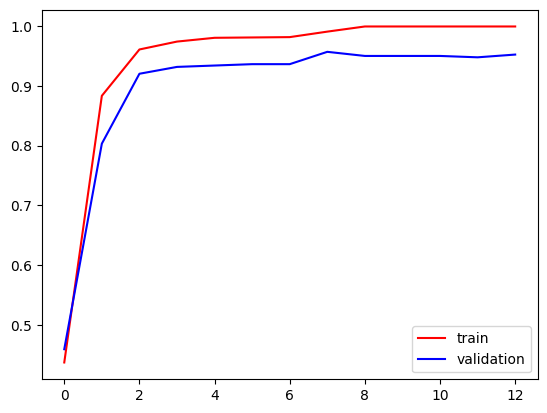

In [14]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

Plotting loss of train and validation set

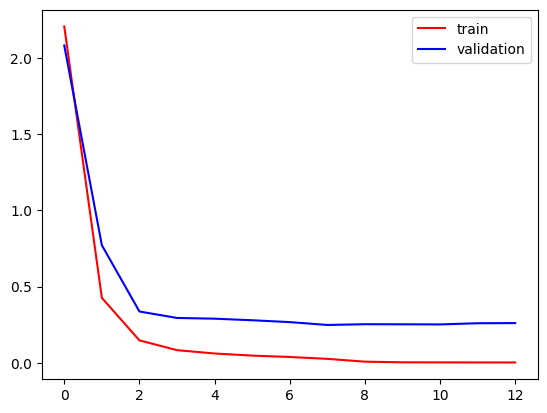

In [15]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

# **Transfer Learning with DenseNet-121**

In [30]:
import cv2
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

def load_data(data_dir):
    path = [os.path.join(data_dir, file) for file in os.listdir(data_dir)]
    faces = []
    names = []

    for image in path:
        img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
        name, ext = os.path.splitext(os.path.basename(image))
        label = name.split(".")[0]  
        faces.append(img)
        names.append(label)
    
    faces = np.array(faces)
    names = np.array(names)
    return faces, names

def encode_labels(names):
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(names)
    return encoded_labels, label_encoder

def split_data(faces, labels):
    train_faces, val_faces, train_labels, val_labels = train_test_split(faces, labels, test_size=0.2, random_state=42, stratify=labels)
    return train_faces, val_faces, train_labels, val_labels

def main(data_dir):
    faces, names = load_data(data_dir)
    print("Original names:")
    for name in names[:10]:  
        print(name)

    train_labels, label_encoder = encode_labels(names)
    
    print(f"Number of classes: {len(label_encoder.classes_)}")
    train_faces, val_faces, train_labels, val_labels = split_data(faces, train_labels)
    print(f"Train labels shape after encoding: {train_labels.shape}, dtype: {train_labels.dtype}")
    print(f"Val labels shape after encoding: {val_labels.shape}, dtype: {val_labels.dtype}")

    return train_faces, val_faces, train_labels, val_labels, label_encoder


data_dir = '/kaggle/input/face-recognition/imgs'  
train_faces, val_faces, train_labels, val_labels, label_encoder = main(data_dir)


Original names:
Prateek Maheshwari
zaid alam
harsh kajalkhane 
vishal meena
SUJIT TAYADE
nikhil chaudhary
Prateek Maheshwari
AMAN KHERIA
harsh kajalkhane 
AMAN KHERIA
Number of classes: 56
Train labels shape after encoding: (1745,), dtype: int64
Val labels shape after encoding: (437,), dtype: int64


In [31]:
batch_size = 32
def preprocess_images(images):
    num_images = len(images)
    processed_images = np.zeros((num_images,) + images.shape[1:] + (3,), dtype=np.float32)

    for start in range(0, num_images, batch_size):
        end = min(start + batch_size, num_images)
        batch_images = images[start:end]

        # Convert and normalize batch of images
        for i, x in enumerate(batch_images):
            rgb_image = cv2.cvtColor(x, cv2.COLOR_GRAY2RGB)
            processed_images[start + i] = rgb_image / 255.0

    return processed_images

train_faces_processed = preprocess_images(train_faces)
val_faces_processed = preprocess_images(val_faces)

In [32]:
target_size = (224, 224)
train_faces_processed_resized = np.zeros((train_faces_processed.shape[0],) + target_size + (3,), dtype=np.float32)
val_faces_processed_resized = np.zeros((val_faces_processed.shape[0],) + target_size + (3,), dtype=np.float32)

for i, img in enumerate(train_faces_processed):
    train_faces_processed_resized[i] = cv2.resize(img, target_size)

for i, img in enumerate(val_faces_processed):
    val_faces_processed_resized[i] = cv2.resize(img, target_size)

In [33]:
train_faces_processed_resized.shape

(1745, 224, 224, 3)

In [34]:
val_faces_processed_resized.shape

(437, 224, 224, 3)

In [35]:
train_faces_processed_resized[0]

array([[[0.11274486, 0.11274486, 0.11274486],
        [0.11374347, 0.11374347, 0.11374347],
        [0.10982065, 0.10982065, 0.10982065],
        ...,
        [0.11064543, 0.11064543, 0.11064543],
        [0.11377755, 0.11377755, 0.11377755],
        [0.11369047, 0.11369047, 0.11369047]],

       [[0.11360341, 0.11360341, 0.11360341],
        [0.11160433, 0.11160433, 0.11160433],
        [0.11353526, 0.11353526, 0.11353526],
        ...,
        [0.11202731, 0.11202731, 0.11202731],
        [0.11476192, 0.11476192, 0.11476192],
        [0.1118352 , 0.1118352 , 0.1118352 ]],

       [[0.11057384, 0.11057384, 0.11057384],
        [0.11540851, 0.11540851, 0.11540851],
        [0.26848948, 0.26848948, 0.26848948],
        ...,
        [0.33291316, 0.33291316, 0.33291316],
        [0.28324354, 0.28324354, 0.28324354],
        [0.12775017, 0.12775017, 0.12775017]],

       ...,

       [[0.11670207, 0.11670207, 0.11670207],
        [0.11277894, 0.11277894, 0.11277894],
        [0.3127801 , 0

In [11]:
val_faces_processed_resized[0]

array([[[0.11372549, 0.11372549, 0.11372549],
        [0.11468814, 0.11468814, 0.11468814],
        [0.11372549, 0.11372549, 0.11372549],
        ...,
        [0.10987395, 0.10987395, 0.10987395],
        [0.1148282 , 0.1148282 , 0.1148282 ],
        [0.1108019 , 0.1108019 , 0.1108019 ]],

       [[0.11272783, 0.11272783, 0.11272783],
        [0.11176611, 0.11176611, 0.11176611],
        [0.11693045, 0.11693045, 0.11693045],
        ...,
        [0.12086718, 0.12086718, 0.12086718],
        [0.12384595, 0.12384595, 0.12384595],
        [0.11577381, 0.11577381, 0.11577381]],

       [[0.11269218, 0.11269218, 0.11269218],
        [0.11985529, 0.11985529, 0.11985529],
        [0.1617511 , 0.1617511 , 0.1617511 ],
        ...,
        [0.20684524, 0.20684524, 0.20684524],
        [0.19627218, 0.19627218, 0.19627218],
        [0.12368698, 0.12368698, 0.12368698]],

       ...,

       [[0.11276221, 0.11276221, 0.11276221],
        [0.13774511, 0.13774511, 0.13774511],
        [0.35129553, 0

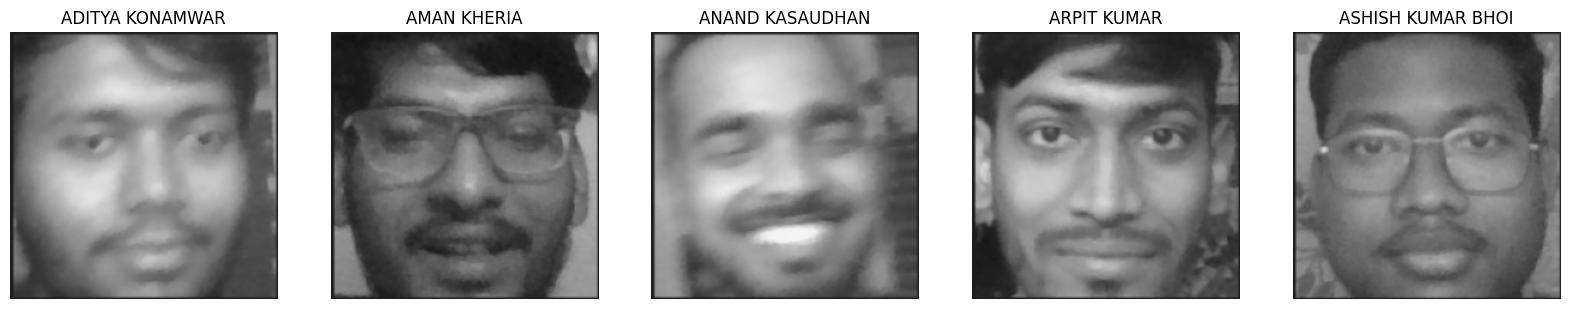

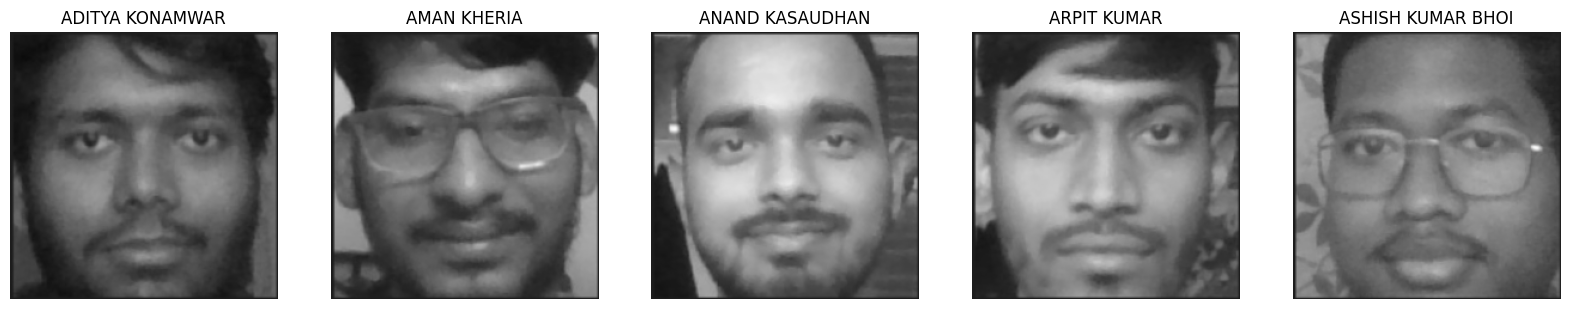

In [54]:
def plot_images(faces, labels, label_encoder, num_images=5):
    unique_labels = np.unique(labels)
    plt.figure(figsize=(20,20))
    for i, label in enumerate(unique_labels[:num_images]):
        idx = np.where(labels == label)[0][0]  
        img = faces[idx]
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(label_encoder.inverse_transform([label])[0])
        plt.axis('off')
    plt.show()

plot_images(train_faces_processed_resized, train_labels, label_encoder)
plot_images(val_faces_processed_resized, val_labels, label_encoder)

In [36]:
from tensorflow.keras.applications import DenseNet121
densenet_base = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

In [25]:
densenet_base.summary()

Model: "densenet121"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 6,953,856 (26.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [37]:
densenet_base.trainable = True

set_trainable = False
for layer in densenet_base.layers:
    if layer.name == 'conv5_block1_1_conv':  
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

for layer in densenet_base.layers:
    print(layer.name, layer.trainable)

input_layer_5 False
zero_padding2d_2 False
conv1_conv False
conv1_bn False
conv1_relu False
zero_padding2d_3 False
pool1 False
conv2_block1_0_bn False
conv2_block1_0_relu False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_concat False
conv2_block2_0_bn False
conv2_block2_0_relu False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv2_block2_concat False
conv2_block3_0_bn False
conv2_block3_0_relu False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_conv False
conv2_block3_concat False
conv2_block4_0_bn False
conv2_block4_0_relu False
conv2_block4_1_conv False
conv2_block4_1_bn False
conv2_block4_1_relu False
conv2_block4_2_conv False
conv2_block4_concat False
conv2_block5_0_bn False
conv2_block5_0_relu False
conv2_block5_1_conv False
conv2_block5_1_bn False
conv2_block5_1_relu False
conv2_block5_2_conv False
conv2_blo

In [58]:
densenet_base.summary()

Model: "densenet121"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 2,159,104 (8.24 MB)

 Non-trainable params: 4,878,400 (18.61 MB)

In [38]:
model_3 = Sequential()

model_3.add(densenet_base)
model_3.add(Flatten())
model_3.add(Dense(64,activation='relu'))
model_3.add(Dense(16,activation='relu'))
model_3.add(Dense(56,activation='softmax'))

In [39]:
adam_optimizer = optimizers.Adam(learning_rate=1e-4)

model_3.compile(optimizer=adam_optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [40]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',  
    patience=5,           
    restore_best_weights=True 
)
history = model_3.fit(
    train_faces_processed_resized,  
    train_labels,                  
    epochs=40,
    validation_data=(val_faces_processed_resized, val_labels),
    callbacks=[early_stopping]
)

Epoch 1/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 86s 754ms/step - accuracy: 0.1667 - loss: 3.2734 - val_accuracy: 0.4096 - val_loss: 2.3449
Epoch 2/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.6086 - loss: 1.3861 - val_accuracy: 0.6865 - val_loss: 1.2851
Epoch 3/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.8113 - loss: 0.6800 - val_accuracy: 0.8398 - val_loss: 0.7814
Epoch 4/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.9086 - loss: 0.4022 - val_accuracy: 0.8787 - val_loss: 0.5676
Epoch 5/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.9206 - loss: 0.2785 - val_accuracy: 0.8833 - val_loss: 0.4683
Epoch 6/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.9380 - loss: 0.1909 - val_accuracy: 0.9176 - val_loss: 0.3927
Epoch 7/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.9659 - loss: 0.1292 - val_accuracy: 0.9199 - val_loss: 0.3787
Epoch 8/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.9755 - loss: 0.0887 - val_accuracy: 0.9382 -

Plotting accuracy of train and validation set

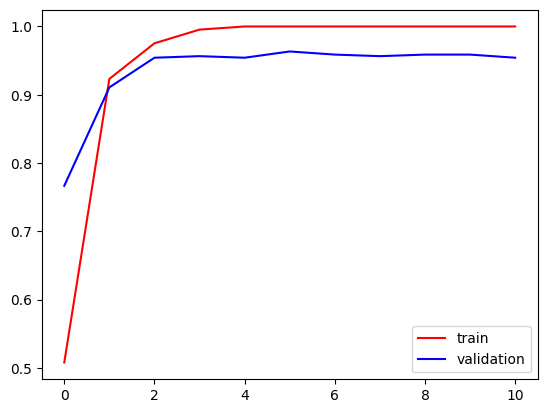

In [50]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

Plotting loss of train and validation set

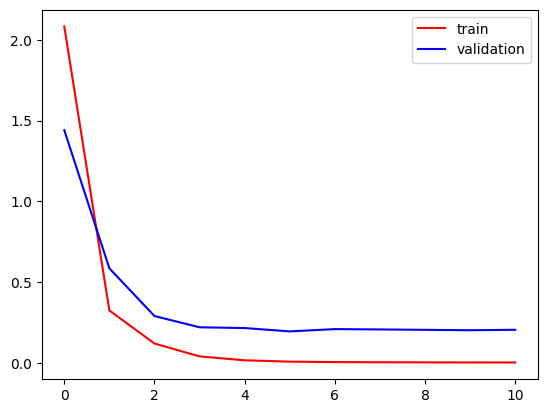

In [51]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

# **Saving the model for Face Prediction**

In [16]:
#Saving the model
model_2.save('inceptionV3_face_recognition_model.h5')
# Saving the label encoder
import pickle
with open('label_encoder.pkl', 'wb') as le_file:
    pickle.dump(label_encoder, le_file)


In [41]:
#Saving the model
model_3.save('densenet121_face_recognition_model.h5')
# Saving the label encoder
import pickle
with open('label_encoder.pkl', 'wb') as le_file:
    pickle.dump(label_encoder, le_file)
